In [180]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

def get_df():
    """Imports and cleans music data in dataframe"""
    df = pd.read_csv('My_Music.csv')
    df.columns = df.columns.str.lower()
    
    #dtypes
    df['date added'] = pd.to_datetime(df['date added'])
    df['last played'] = pd.to_datetime(df['last played'])
    
    #Loved
    df.drop(df[df['loved'] == '5/31/2016 7:03 PM'].index, inplace=True)
    df.drop(df[df['loved'].isnull() == True].index, inplace=True)
    df.loc[:,'loved'] = df['loved'].astype(int) > 0
    
    #rating to stars
    df.loc[:,'rating'].fillna(0, inplace=True)
    df.loc[:,'rating'] = df['rating']/20
    df.loc[:,'rating'] = df['rating'].astype(float)
    df.rename(columns={'rating':'stars', 'name':'song'}, inplace=True)
    df.loc[(df[(df['stars'] > 2) & (df['loved'] == False)].index), 'stars'] = 0
    
    return df

get_df().sort_values('date added', ascending=False).head()

,album artist,song,time,artist,album,genre,loved,plays,date added,stars,year,last played
3178,NaN,Caledonia Soul Music,17:15,Van Morrison,NaN,Jam Session,True,4.0,2020-09-11 13:03:00,0.0,NaN,2020-09-12 11:11:00
3179,Jim Croce,Operator (That's Not the Way It Feels),3:50,Jim Croce,You Don't Mess Around With Jim,Rock,False,2.0,2020-09-10 23:26:00,0.0,1972.0,2020-09-12 11:15:00
3180,Jim Croce,"Bad, Bad Leroy Brown",3:02,Jim Croce,Life & Times,Rock,True,3.0,2020-09-10 23:18:00,0.0,1973.0,2020-09-12 11:23:00
3181,Bon Iver,U (Man Like),2:26,Bon Iver,"i,i",Alternative,False,2.0,2020-09-10 22:04:00,0.0,2019.0,2020-09-12 11:25:00
3182,Bon Iver,Jelmore,2:30,Bon Iver,"i,i",Alternative,False,2.0,2020-09-10 22:04:00,0.0,2019.0,2020-09-12 11:27:00


In [250]:
def get_artist_stats(listened_since = '1990', added_since = '1990', sort = 'adj. rating', added_before = '2040'):
    """
    Returns a sorted pivot table containing information on artists whose songs have been played 
    since a given datetime. Aggregates statistics such as total number of stars, total number of 
    plays of the songs, and number of songs. Features have been added by which artists might be 
    measured against each other.
    """
    
    df = get_df()
    df = df[df['last played'] > listened_since]
    df = df[df['date added'] < added_before]    
    df = df[df['date added'] > added_since]
    
    df.loc[(df[(df['stars'] == 0) & (df['loved'] == True)].index), 'stars'] = 2.5
    df.loc[(df[(df['stars'] == 2)].index), 'stars'] = 0

    df['weeks'] = ((np.max(df['date added']) - df['date added']).dt.days+7)/7
    #df['plays per week'] = (df['plays'] / (df['weeks']))
    # transform data
    df['plays per week'] = (df['plays'] / (df['weeks']+40)) *(6/5)
    df['adj. rating'] = df['stars']**2 / 2.5
    df['comp. score'] = df['stars']**2 / 2.5 + np.sqrt(df['plays'])
    #testdf = df.sort_values('plays per week', ascending = False)

    df = df[['artist', 'song', 'stars', 'plays', 
             'plays per week', 'loved', 'adj. rating', 
             'comp. score', 'year']].groupby('artist').agg({'song':'count', 'loved':sum, 'stars':sum, 
                                                            'adj. rating':sum, 'plays':sum, 'plays per week':sum,
                                                            'comp. score':sum, 'year':'mean' }
                                                            ).round(0).fillna(0).astype(int)
    df.rename(columns = {'song': 'songs', 'year':'avg. year'}, inplace=True)
    
    #Feature Engineering
    df['(songs / loved)'] = (df['songs'] / df['loved']).round(2)
    df['(songs / loved)'].replace(np.inf, 0, inplace=True)    
    
    df['(stars / songs)'] = (df['stars'] / df ['songs']).round(1)

    df['(comp.**2 / loved)'] = (df['comp. score']**2 / df['loved']).round(1)
    df['(comp.**2 / loved)'].replace(np.inf, 0, inplace=True)
    
    df['(adj. rating * (songs/loved))'] = (df['adj. rating'] * (df['songs']/df['loved'])).round(1)
    
    df['Stat Composite'] = ((df['songs']/np.max(df['songs']) + df['loved']/np.max(df['loved']) + df['stars']/np.max(df['stars']) + df['plays']/np.max(df['plays']) + df['plays per week']/np.max(df['plays per week']) + df['adj. rating']/np.max(df['adj. rating']))*(100/6)).round(2)
    df['Feature Composite'] = ((df['(comp.**2 / loved)']/np.max(df['(comp.**2 / loved)']) + df['(adj. rating * (songs/loved))']/np.max(df['(adj. rating * (songs/loved))']))*(100/2)).round(2)

    #plt.figure()
    #plt.scatter(testdf['date added'], testdf['plays per week'])
    
    return df.sort_values(sort, ascending=False)
    #return testdf

get_artist_stats(listened_since = '2018', sort='Stat Composite').head(25)

,songs,loved,stars,adj. rating,plays,plays per week,comp. score,avg. year,(songs / loved),(stars / songs),(comp.**2 / loved),(adj. rating * (songs/loved)),Stat Composite,Feature Composite
artist,,,,,,,,,,,,,,
John Mayer,111,59,206,314,3282,16,870,2008,1.88,1.9,12828.8,590.7,99.71,100.00
Jack Johnson,113,45,144,200,2044,9,632,2008,2.51,1.3,8876.1,502.2,71.40,77.10
Jason Mraz,47,27,99,151,1065,4,343,2010,1.74,2.1,4357.4,262.9,40.16,39.24
Zac Brown Band,47,26,90,132,1211,5,331,2015,1.81,1.9,4213.9,238.6,39.92,36.62
Lord Huron,40,22,80,125,1021,6,317,2015,1.82,2.0,4567.7,227.3,36.66,37.04
The California Honeydrops,44,17,60,90,664,10,247,2017,2.59,1.4,3588.8,232.9,34.71,33.70
Ben Howard,46,18,78,139,713,4,304,2014,2.56,1.7,5134.2,355.2,33.35,50.08
Ed Sheeran,48,22,74,105,766,4,275,2015,2.18,1.5,3437.5,229.1,32.91,32.79
The Tallest Man On Earth,44,20,70,106,654,5,257,2013,2.20,1.6,3302.4,233.2,31.96,32.61


In [251]:
def get_genre_stats(listened_since = '1990', added_since = '1990', sort = 'stars'):
    """
    Returns a sorted pivot table containing information on artists whose songs have been 
    played since a given datetime. Aggregates total number of stars, total number of plays 
    of the songs, and number of songs.
    """
    
    
    df = get_df()
    df = df[df['last played'] > listened_since]
    df = df[df['date added'] > added_since]
    df = df[['genre', 'song', 'stars', 'plays', 'loved']].groupby('genre').agg({'song':'count', 
                                                                                  'stars':sum, 
                                                                                  'loved':sum,
                                                                                  'plays':sum, }).astype(int)
    df.rename(columns = {'song': 'songs'}, inplace=True)
    
    return df.sort_values(sort, ascending=False)

get_genre_stats().head(15)

,songs,stars,loved,plays
genre,,,,
Pop,1339,1241,470,14544
Dance,636,735,222,7389
Alternative,780,650,210,7947
Rock,545,483,186,7832
Country,314,285,114,5340
Hip-Hop/Rap,280,269,106,1387
R&B/Soul,261,244,102,2378
Singer/Songwriter,304,208,73,2795
Rap & Hip-Hop,444,187,87,3249


In [277]:
def top_artists(songtolovedfactor = 1.5, listened_since = '2019', added_before = '2040', added_since = '2016', styler=False):
    """
    Returns a sorted list of top artists, excluding artists that fall beneath given thresholds 
    """
    df = get_artist_stats(listened_since = listened_since, added_before=added_before, 
                          added_since=added_since, sort='Stat Composite').drop('avg. year', axis=1)
    df = df[(df['loved'] > 4) & (df['(songs / loved)'] > songtolovedfactor)]
    if styler == True:
        return df.style.background_gradient(cmap='YlOrRd')
    else:
        return df

top_artists(added_since='2016',styler=True)

,songs,loved,stars,adj. rating,plays,plays per week,comp. score,(songs / loved),(stars / songs),(comp.**2 / loved),(adj. rating * (songs/loved)),Stat Composite,Feature Composite
artist,,,,,,,,,,,,,
John Mayer,87,46,154,226,2507,12,663,1.890000,1.800000,9555.800000,427.400000,98.280000,100.000000
Jack Johnson,97,41,128,175,1760,8,551,2.370000,1.300000,7404.900000,414.000000,81.090000,87.180000
Lord Huron,39,22,80,125,1014,5,315,1.770000,2.100000,4510.200000,221.600000,46.230000,49.520000
The California Honeydrops,44,17,60,90,664,10,247,2.590000,1.400000,3588.800000,232.900000,45.150000,46.020000
Ben Howard,44,18,78,139,701,4,300,2.440000,1.800000,5000.000000,339.800000,42.990000,65.910000
The Tallest Man On Earth,32,19,66,100,567,4,222,1.680000,2.100000,2593.900000,168.400000,36.220000,33.270000
Leon Bridges,27,9,33,51,544,6,165,3.000000,1.200000,3025.000000,153.000000,27.180000,33.730000
Hozier,34,11,41,64,327,3,155,3.090000,1.200000,2184.100000,197.800000,25.330000,34.570000
ODESZA,33,8,30,49,608,3,178,4.120000,0.900000,3960.500000,202.100000,23.640000,44.370000


<IPython.core.display.Javascript object>


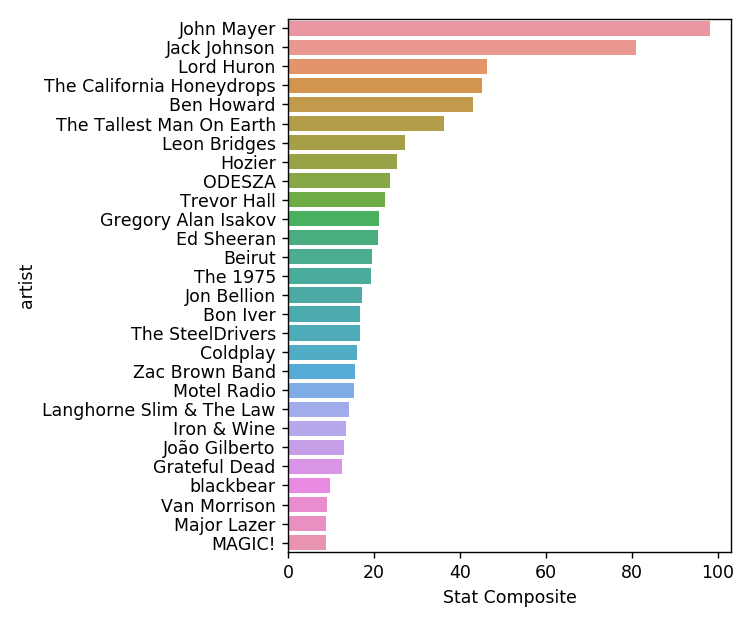

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

top = top_artists()

fig = plt.figure(figsize=(6,5))
sns.barplot(top['Stat Composite'], top.index)
fig.tight_layout()

<IPython.core.display.Javascript object>


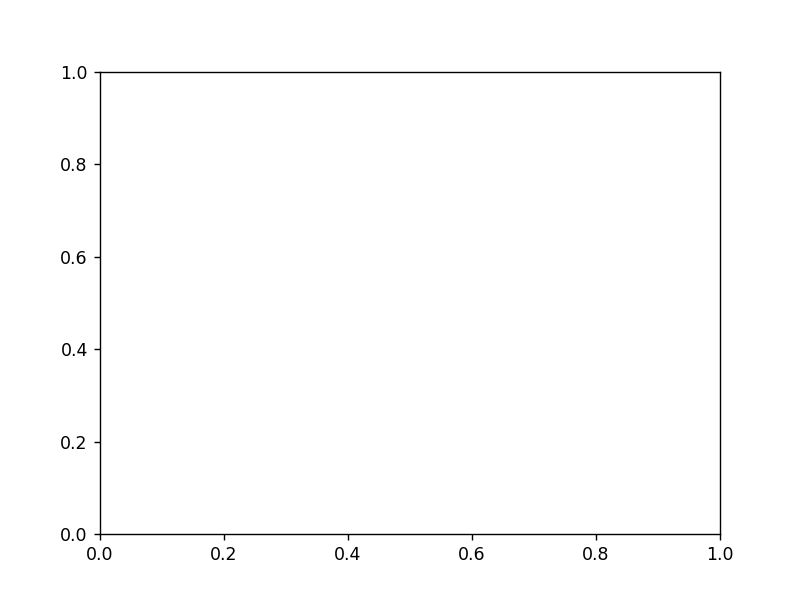

In [135]:
n=88
def update(curr):
    print('running...')
    if curr == n:
        a.event_source.stop()
    plt.cla()
    x = datetime.datetime(2013,8,1) + curr * timedelta(days=365/12)
    top = top_artists(added_before = x, listened_since = '2016').head(15)
    sns.barplot(top['comp. score'], top.index)
    fig.tight_layout()
    plt.annotate('Added before {}'.format(x.date()), (310,47), xycoords='figure points')

%matplotlib notebook
fig = plt.figure()
a = animation.FuncAnimation(fig, update, interval=500)


#a.save('compbydateadded.mp4')